In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import os
import jieba
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot, text_to_word_sequence, Tokenizer
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from keras.callbacks import EarlyStopping,ModelCheckpoint
import keras.backend as K


Using TensorFlow backend.


In [2]:
def get_engine(db_name=''):
    db_dir='/media/disk3/feynman52/See26/crawler-ryh'
    db_url = 'sqlite:///'+db_dir+'/'+db_name
    engine = create_engine(db_url, echo = False)
    return engine

def sql_to_df(engine,query=''):
    df = pd.read_sql_query(query, engine)
    return df

def set_jieba_dictionary():
    jieba_dit_path = os.path.join('.','dataset','dict.txt.big')
    jieba.set_dictionary(jieba_dit_path) 

set_jieba_dictionary()
engine=get_engine(db_name='articles.db')


In [3]:

query='''
select * from article where article_title like "%長榮%"
'''
articles=sql_to_df(engine,query=query)
article_ids=articles.article_id.tolist()
article_ids=[str(x) for x in article_ids]
article_ids=','.join(article_ids)

articles.head(1)

,article_id,article_user,article_group,article_title,article_time,article_weekday,article_ip,article_url
0,3,catwalk456,Gossiping,[新聞] 多瑙河畔響起中華民國國歌 長榮機長空姐,2018-10-11 12:04:16,3,125.227.50.235,https://www.ptt.cc/bbs/Gossiping/M.1539230659....


In [4]:
query='''
select * from push where article_id in (%s)
'''%(article_ids)

pushs=sql_to_df(engine,query=query)

pushs.head(1)


,push_id,push_user,push_tag,push_time,push_content,push_weekday,push_ip,article_id
0,208,xxx60133,→,2018-10-11 12:05:00,現在都要拖出來鞭膩,3,42.76.49.49,3


In [5]:
len(articles),len(pushs)

(566, 34990)

In [6]:
df_all=pushs[['push_tag','push_content']].copy()
df_all['label']=df_all['push_tag'].map({'推':1,'噓':0,'→':'missing',})
df_all['push_content_cut'] = df_all['push_content'].apply(lambda x: jieba.lcut(x))
df_all['push_content_cut_join'] = df_all['push_content_cut'].apply(lambda x: ' '.join(x))
df_all.head(5)

Building prefix dict from /media/disk3/feynman52/See26/model/dataset/dict.txt.big ...
Loading model from cache /tmp/jieba.uc8f590617510cc546ef7e6a3a5db2cd4.cache
Loading model cost 3.259 seconds.
Prefix dict has been built succesfully.


,push_tag,push_content,label,push_content_cut,push_content_cut_join
0,→,現在都要拖出來鞭膩,missing,"[現在, 都, 要, 拖出來, 鞭膩]",現在 都 要 拖出來 鞭膩
1,推,抓到了 抵制台獨,1,"[抓到, 了, , 抵制, 台獨]",抓到 了 抵制 台獨
2,→,9.2%的國歌是不可以在台灣外面播的,missing,"[9.2%, 的, 國歌, 是, 不, 可以, 在, 台灣, 外面, 播, 的]",9.2% 的 國歌 是 不 可以 在 台灣 外面 播 的
3,→,"年代不同現在這樣還要趕快下架,怕秋後算賬",missing,"[年代, 不同, 現在, 這樣, 還要, 趕快, 下架, ,, 怕, 秋後算賬]","年代 不同 現在 這樣 還要 趕快 下架 , 怕 秋後算賬"
4,→,我不停的追逐 那黑色的幸福,missing,"[我, 不停, 的, 追逐, , 那, 黑色, 的, 幸福]",我 不停 的 追逐 那 黑色 的 幸福


In [7]:
def train_tokenizer(strings=['thank','you'],num_words=20000):
    tok = Tokenizer(num_words=num_words,
                    filters='"!#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                    lower=True,
                    split=' ', 
                    char_level=False)
    tok.fit_on_texts(strings)
    return tok

num_words=30000
strings=df_all.push_content_cut_join.tolist()
tok = train_tokenizer(strings=strings,num_words= num_words)

In [8]:
# tok.texts_to_sequences(['的 了'])

In [9]:
df_all['sequence']=df_all.push_content_cut_join.apply(lambda x: tok.texts_to_sequences([x])[0])
df_all.head()

,push_tag,push_content,label,push_content_cut,push_content_cut_join,sequence
0,→,現在都要拖出來鞭膩,missing,"[現在, 都, 要, 拖出來, 鞭膩]",現在 都 要 拖出來 鞭膩,"[78, 10, 12, 5576, 10469]"
1,推,抓到了 抵制台獨,1,"[抓到, 了, , 抵制, 台獨]",抓到 了 抵制 台獨,"[3500, 4, 2879, 4608]"
2,→,9.2%的國歌是不可以在台灣外面播的,missing,"[9.2%, 的, 國歌, 是, 不, 可以, 在, 台灣, 外面, 播, 的]",9.2% 的 國歌 是 不 可以 在 台灣 外面 播 的,"[573, 228, 1, 10470, 3, 9, 27, 20, 90, 1012, 7..."
3,→,"年代不同現在這樣還要趕快下架,怕秋後算賬",missing,"[年代, 不同, 現在, 這樣, 還要, 趕快, 下架, ,, 怕, 秋後算賬]","年代 不同 現在 這樣 還要 趕快 下架 , 怕 秋後算賬","[2880, 477, 78, 60, 160, 443, 5577, 257, 2676]"
4,→,我不停的追逐 那黑色的幸福,missing,"[我, 不停, 的, 追逐, , 那, 黑色, 的, 幸福]",我 不停 的 追逐 那 黑色 的 幸福,"[15, 4609, 1, 10471, 50, 7157, 1, 2881]"


In [10]:
# dir(tok)
word2index=tok.word_index
[word2index[word] for word in df_all.loc[0,'push_content_cut']]

[78, 10, 12, 5576, 10469]

In [11]:
# pad_sequences([[1,2]], maxlen=50, padding='pre')[0]

In [12]:
maxlen=50

df_all['padding']=df_all.sequence.apply(
    lambda x: pad_sequences([x], maxlen=maxlen, padding='pre')[0])

df_all.head(2)


,push_tag,push_content,label,push_content_cut,push_content_cut_join,sequence,padding
0,→,現在都要拖出來鞭膩,missing,"[現在, 都, 要, 拖出來, 鞭膩]",現在 都 要 拖出來 鞭膩,"[78, 10, 12, 5576, 10469]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,推,抓到了 抵制台獨,1,"[抓到, 了, , 抵制, 台獨]",抓到 了 抵制 台獨,"[3500, 4, 2879, 4608]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [13]:
c=df_all.label!='missing'
df_train=df_all[c]

c=df_all.label=='missing'
df_test=df_all[c]

display(df_train.head(2))
display(df_test.head(2))

,push_tag,push_content,label,push_content_cut,push_content_cut_join,sequence,padding
1,推,抓到了 抵制台獨,1,"[抓到, 了, , 抵制, 台獨]",抓到 了 抵制 台獨,"[3500, 4, 2879, 4608]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,噓,會酸這種的都9.2跟五毛,0,"[會酸, 這種, 的, 都, 9.2, 跟, 五毛]",會酸 這種 的 都 9.2 跟 五毛,"[7158, 76, 1, 10, 573, 228, 29, 2028]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


,push_tag,push_content,label,push_content_cut,push_content_cut_join,sequence,padding
0,→,現在都要拖出來鞭膩,missing,"[現在, 都, 要, 拖出來, 鞭膩]",現在 都 要 拖出來 鞭膩,"[78, 10, 12, 5576, 10469]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,→,9.2%的國歌是不可以在台灣外面播的,missing,"[9.2%, 的, 國歌, 是, 不, 可以, 在, 台灣, 外面, 播, 的]",9.2% 的 國歌 是 不 可以 在 台灣 外面 播 的,"[573, 228, 1, 10470, 3, 9, 27, 20, 90, 1012, 7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
x_all=np.array(df_train.padding.tolist())
y_all=np.array(df_train.label.tolist())

x_test=np.array(df_test.padding.tolist())

x_all.shape,y_all.shape,x_test.shape

((17619, 50), (17619,), (17371, 50))

In [15]:
x_train, x_valid, y_train, y_valid = train_test_split(x_all, y_all, test_size=0.1, random_state=42)

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((15857, 50), (1762, 50), (15857,), (1762,))

In [16]:
print(num_words,maxlen)

30000 50


In [17]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=100, input_length=maxlen))


model.add(SpatialDropout1D(0.4))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           3000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 3,085,501
Trainable params: 3,085,501
Non-trainable params: 0
_________________________________________________________________


In [18]:
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

early_stopping = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=10, min_delta=0.001)

dir_name='flight'
dir_path=os.path.join('.','dataset','weights',dir_name)
make_dir(dir_path)

file_name = 'sentiment'
file_name += '-'+"epoch_{epoch:02d}-val_acc_{val_acc:.3f}.hdf5"
path=os.path.join(dir_path,file_name)
checkpointer = ModelCheckpoint(filepath=path, verbose=1, monitor='val_acc', save_best_only=True, mode='max', period=1)


In [19]:
    
batch_size=1000
epochs=100

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    validation_data=[x_valid,y_valid],
                    callbacks=[early_stopping,checkpointer])

Train on 15857 samples, validate on 1762 samples
Epoch 1/100
15857/15857 [==============================] - 16s 1ms/step - loss: 0.6405 - acc: 0.6991 - val_loss: 0.6099 - val_acc: 0.7060

Epoch 00001: val_acc improved from -inf to 0.70602, saving model to ./dataset/weights/flight/sentiment-epoch_01-val_acc_0.706.hdf5
Epoch 2/100
15857/15857 [==============================] - 2s 134us/step - loss: 0.6048 - acc: 0.7028 - val_loss: 0.5982 - val_acc: 0.7060

Epoch 00002: val_acc did not improve from 0.70602
Epoch 3/100
15857/15857 [==============================] - 2s 131us/step - loss: 0.5868 - acc: 0.7033 - val_loss: 0.5858 - val_acc: 0.7043

Epoch 00003: val_acc did not improve from 0.70602
Epoch 4/100
15857/15857 [==============================] - 2s 125us/step - loss: 0.5443 - acc: 0.7184 - val_loss: 0.5657 - val_acc: 0.7134

Epoch 00004: val_acc improved from 0.70602 to 0.71339, saving model to ./dataset/weights/flight/sentiment-epoch_04-val_acc_0.713.hdf5
Epoch 5/100
15857/15857 [==

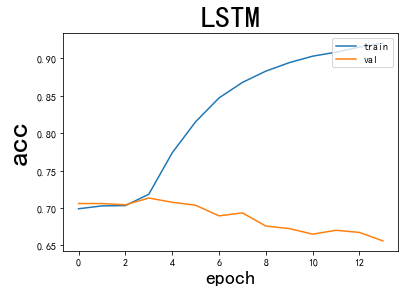

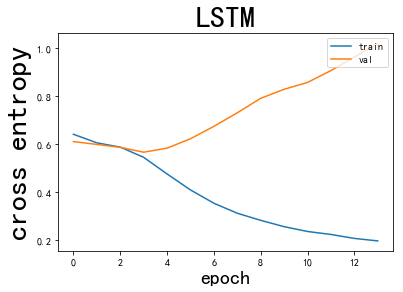

In [20]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('LSTM', fontsize=30)
plt.ylabel('acc', fontsize=30)
plt.xlabel('epoch', fontsize=20)
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM', fontsize=30)
plt.ylabel('cross entropy', fontsize=30)
plt.xlabel('epoch', fontsize=20)
plt.legend(['train', 'val'], loc='upper right')
plt.show()

- load best model

In [23]:
weights=glob(os.path.join(dir_path,'*')) 
weights.sort()
best_weight=weights[-1]
print(best_weight)

best_nn=load_model(best_weight)

./dataset/weights/flight/sentiment-epoch_04-val_acc_0.713.hdf5


In [30]:
y_test=best_nn.predict(x_test).reshape(-1)

In [36]:
y_test=[int(round(y)) for y in y_test]

In [46]:
df_all['label2']=df_all['label']
c=df_all.label2=='missing'
df_all.loc[c,'label2']=y_test
df_all.tail()

,push_tag,push_content,label,push_content_cut,push_content_cut_join,sequence,padding,label2
34985,→,哈哈哈死好,missing,"[哈哈哈, 死, 好]",哈哈哈 死 好,"[261, 49, 23]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
34986,→,這殺小工會,missing,"[這殺, 小, 工會]",這殺 小 工會,"[23932, 166, 17]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
34987,推,剛好而已不是嗎？,1,"[剛好, 而已, 不是, 嗎, ？]",剛好 而已 不是 嗎 ？,"[414, 170, 34, 16, 5]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
34988,噓,OP,0,[OP],OP,[4182],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
34989,→,"郭董:""暴政必亡!!""",missing,"[ , 郭董, :, "", 暴政, 必亡, !, !, ""]","郭董 : "" 暴政 必亡 ! ! ""","[5127, 23933, 23934]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


In [47]:
pushs['label']=df_all['label2']
pushs.tail()

,push_id,push_user,push_tag,push_time,push_content,push_weekday,push_ip,article_id,label
34985,35193,Pheromone,→,2019-09-01 22:24:00,哈哈哈死好,6,42.72.155.30,568,1
34986,35194,zxc90147,→,2019-09-01 23:10:00,這殺小工會,6,42.75.122.114,568,1
34987,35195,hellam,推,2019-09-02 00:05:00,剛好而已不是嗎？,0,117.19.147.15,568,1
34988,35196,TobyH4cker,噓,2019-09-02 18:25:00,OP,0,36.227.225.178,568,0
34989,35197,gwenwoo,→,2019-09-02 21:16:00,"郭董:""暴政必亡!!""",0,114.32.164.59,568,1


In [50]:
result=pd.merge(left=pushs,right=articles,on='article_id',how='inner')
result.tail()

,push_id,push_user,push_tag,push_time,push_content,push_weekday,push_ip,article_id,label,article_user,article_group,article_title,article_time,article_weekday,article_ip,article_url
34985,35193,Pheromone,→,2019-09-01 22:24:00,哈哈哈死好,6,42.72.155.30,568,1,Government,Gossiping,[新聞] 空服員工會爆「秋後算帳」長榮空姐！,2019-09-01 18:31:05,6,223.140.78.45,https://www.ptt.cc/bbs/Gossiping/M.1567333868....
34986,35194,zxc90147,→,2019-09-01 23:10:00,這殺小工會,6,42.75.122.114,568,1,Government,Gossiping,[新聞] 空服員工會爆「秋後算帳」長榮空姐！,2019-09-01 18:31:05,6,223.140.78.45,https://www.ptt.cc/bbs/Gossiping/M.1567333868....
34987,35195,hellam,推,2019-09-02 00:05:00,剛好而已不是嗎？,0,117.19.147.15,568,1,Government,Gossiping,[新聞] 空服員工會爆「秋後算帳」長榮空姐！,2019-09-01 18:31:05,6,223.140.78.45,https://www.ptt.cc/bbs/Gossiping/M.1567333868....
34988,35196,TobyH4cker,噓,2019-09-02 18:25:00,OP,0,36.227.225.178,568,0,Government,Gossiping,[新聞] 空服員工會爆「秋後算帳」長榮空姐！,2019-09-01 18:31:05,6,223.140.78.45,https://www.ptt.cc/bbs/Gossiping/M.1567333868....
34989,35197,gwenwoo,→,2019-09-02 21:16:00,"郭董:""暴政必亡!!""",0,114.32.164.59,568,1,Government,Gossiping,[新聞] 空服員工會爆「秋後算帳」長榮空姐！,2019-09-01 18:31:05,6,223.140.78.45,https://www.ptt.cc/bbs/Gossiping/M.1567333868....


In [51]:
path=os.path.join('.','dataset','flight.pickle')
result.to_pickle(path)